# Supply Chain Demand Forecasting

## Objective
Forecast **weekly demand** using historical retail sales data to support
inventory planning and reduce stock-outs and overstocking.

This project demonstrates the **complete ML lifecycle**:
- Data cleaning & EDA
- Time-series feature engineering
- Baseline vs ML comparison
- Model evaluation
- Explainability
- Deployment-ready artifacts


IMPORT LIBRARIES

In [46]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import joblib
import os

pd.set_option("display.max_columns", None)


LOAD DATA

In [47]:
data_path = "data/retail_demand.csv"
df = pd.read_csv(data_path)

# Clean column names
df.columns = df.columns.str.strip()

df.head()


,Product_id,Product_Code,Warehouse,Product_Category,Date,Order_Demand,Open,Promo,StateHoliday,SchoolHoliday,Petrol_price
0,786725,Product_0033,Whse_S,Category_005,01/03/2016,16000,1,0,0,0,91
1,786743,Product_1825,Whse_S,Category_006,01/03/2016,50000,1,0,0,0,85
2,786967,Product_0551,Whse_S,Category_030,01/03/2016,3000,1,0,0,0,85
3,786856,Product_0556,Whse_S,Category_030,01/03/2016,1000,1,0,0,0,93
4,899538,Product_1844,Whse_A,Category_018,01/03/2016,7,1,0,0,0,95


BASIC INSPECTION

In [48]:
df.shape


(169211, 11)

In [49]:
df.columns


Index(['Product_id', 'Product_Code', 'Warehouse', 'Product_Category', 'Date',
       'Order_Demand', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday',
       'Petrol_price'],
      dtype='str')

In [50]:
df.info()


<class 'pandas.DataFrame'>
RangeIndex: 169211 entries, 0 to 169210
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype
---  ------            --------------   -----
 0   Product_id        169211 non-null  int64
 1   Product_Code      169211 non-null  str  
 2   Warehouse         169211 non-null  str  
 3   Product_Category  169211 non-null  str  
 4   Date              169211 non-null  str  
 5   Order_Demand      169211 non-null  int64
 6   Open              169211 non-null  int64
 7   Promo             169211 non-null  int64
 8   StateHoliday      169211 non-null  str  
 9   SchoolHoliday     169211 non-null  int64
 10  Petrol_price      169211 non-null  int64
dtypes: int64(6), str(5)
memory usage: 14.2 MB


DATE PARSING (NO ERRORS, MIXED FORMAT SAFE)

In [51]:
df["Date"] = pd.to_datetime(
    df["Date"],
    errors="coerce",
    dayfirst=False
)

# Drop rows where date parsing failed
df = df.dropna(subset=["Date"]).reset_index(drop=True)

df["Date"].min(), df["Date"].max()


(Timestamp('2016-01-03 00:00:00'), Timestamp('2016-11-23 00:00:00'))

TARGET OVERVIEW

In [53]:
df["Order_Demand"].describe()


count    1.692110e+05
mean     5.248118e+03
std      3.116296e+04
min      0.000000e+00
25%      2.000000e+01
50%      3.000000e+02
75%      2.000000e+03
max      2.500000e+06
Name: Order_Demand, dtype: float64

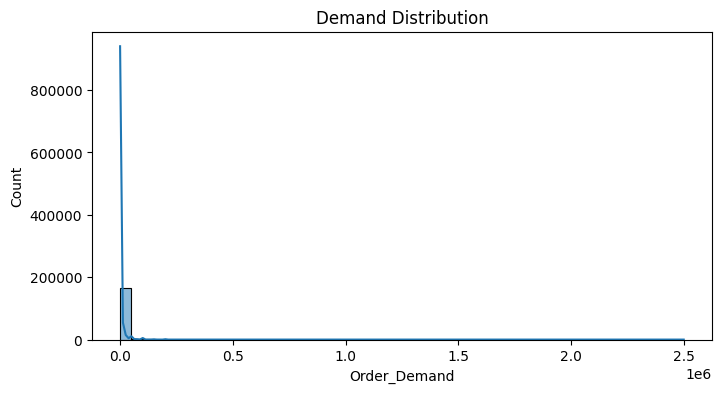

In [54]:
plt.figure(figsize=(8,4))
sns.histplot(df["Order_Demand"], bins=50, kde=True)
plt.title("Demand Distribution")
plt.show()


HANDLE MISSING VALUES

In [55]:
# Drop rows with missing target
df = df.dropna(subset=["Order_Demand"])

# Fill categorical missing values
categorical_cols = df.select_dtypes(include="object").columns
df[categorical_cols] = df[categorical_cols].fillna("Unknown")

df.isnull().sum()


C:\Users\SIDDHARTH\AppData\Local\Temp\ipykernel_22348\4241168669.py:5: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  categorical_cols = df.select_dtypes(include="object").columns


Product_id          0
Product_Code        0
Warehouse           0
Product_Category    0
Date                0
Order_Demand        0
Open                0
Promo               0
StateHoliday        0
SchoolHoliday       0
Petrol_price        0
dtype: int64

AGGREGATE TO WEEKLY DEMAND (STABLE ✅)

In [56]:
# Set Date as index safely
df = df.set_index("Date")

weekly_df = (
    df
    .resample("W")["Order_Demand"]
    .sum()
    .reset_index()
)

weekly_df.head()


,Date,Order_Demand
0,2016-01-03,95439
1,2016-01-10,21266253
2,2016-01-17,19764462
3,2016-01-24,21424387
4,2016-01-31,16077078


WEEKLY DEMAND VISUALIZATION

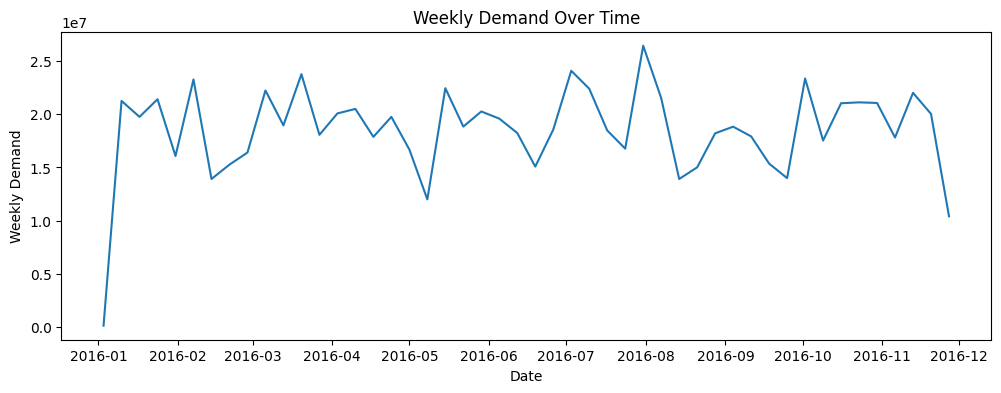

In [57]:
plt.figure(figsize=(12,4))
plt.plot(weekly_df["Date"], weekly_df["Order_Demand"])
plt.title("Weekly Demand Over Time")
plt.xlabel("Date")
plt.ylabel("Weekly Demand")
plt.show()


FEATURE ENGINEERING (TIME-SERIES)

In [58]:
weekly_df["lag_1"] = weekly_df["Order_Demand"].shift(1)
weekly_df["lag_2"] = weekly_df["Order_Demand"].shift(2)
weekly_df["lag_3"] = weekly_df["Order_Demand"].shift(3)

weekly_df["rolling_mean_3"] = weekly_df["Order_Demand"].rolling(3).mean()
weekly_df["rolling_std_3"]  = weekly_df["Order_Demand"].rolling(3).std()

weekly_df["week"]  = weekly_df["Date"].dt.isocalendar().week.astype(int)
weekly_df["month"] = weekly_df["Date"].dt.month
weekly_df["year"]  = weekly_df["Date"].dt.year


DROP NaNs FROM LAGS

In [59]:
weekly_df = weekly_df.dropna().reset_index(drop=True)
weekly_df.shape


(45, 10)

TRAIN / VALIDATION / TEST SPLIT (TIME-AWARE)

In [60]:
X = weekly_df.drop(columns=["Order_Demand", "Date"])
y = weekly_df["Order_Demand"]

train_size = int(len(weekly_df) * 0.7)
val_size   = int(len(weekly_df) * 0.85)

X_train = X.iloc[:train_size]
X_val   = X.iloc[train_size:val_size]
X_test  = X.iloc[val_size:]

y_train = y.iloc[:train_size]
y_val   = y.iloc[train_size:val_size]
y_test  = y.iloc[val_size:]


BASELINE MODEL (NAIVE)

In [61]:
baseline_pred = y_val.shift(1).dropna()
baseline_true = y_val.loc[baseline_pred.index]

baseline_rmse = np.sqrt(
    mean_squared_error(baseline_true, baseline_pred)
)

baseline_rmse


np.float64(4687620.804948551)

LINEAR REGRESSION

In [62]:
lr = LinearRegression()
lr.fit(X_train, y_train)

lr_pred = lr.predict(X_val)
lr_rmse = np.sqrt(mean_squared_error(y_val, lr_pred))

lr_rmse


np.float64(4.562530187486071e-09)

RANDOM FOREST (FINAL MODEL)

In [64]:
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

rf_pred = rf.predict(X_val)
rf_rmse = np.sqrt(mean_squared_error(y_val, rf_pred))

rf_rmse


np.float64(2490997.4509383775)

FINAL TRAINING (TRAIN + VAL)

In [65]:
X_final = pd.concat([X_train, X_val])
y_final = pd.concat([y_train, y_val])

final_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

final_model.fit(X_final, y_final)


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",200
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",10
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples 

TEST SET EVALUATION

In [66]:
test_pred = final_model.predict(X_test)

test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
test_rmse


np.float64(3032218.688962525)

FEATURE IMPORTANCE

In [67]:
importance = pd.Series(
    final_model.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

importance


rolling_mean_3    0.351711
rolling_std_3     0.169720
lag_2             0.140022
lag_1             0.137837
lag_3             0.099203
week              0.070411
month             0.031095
year              0.000000
dtype: float64

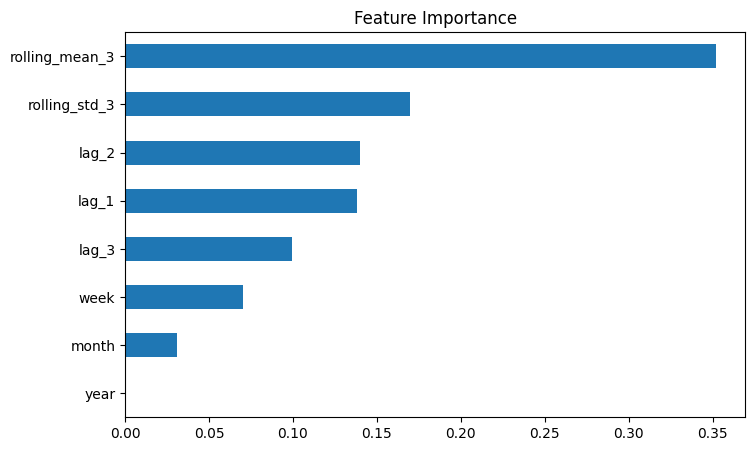

In [68]:
plt.figure(figsize=(8,5))
importance.plot(kind="barh")
plt.title("Feature Importance")
plt.gca().invert_yaxis()
plt.show()


SAVE MODEL & METADATA

In [69]:
os.makedirs("models", exist_ok=True)

joblib.dump(final_model, "models/final_model.joblib")
joblib.dump(list(X.columns), "models/feature_columns.joblib")


['models/feature_columns.joblib']